# Import data and dependencies

In [1]:
# !pip install underthesea matplotlib==3.7.3 seaborn wordcloud jupyternotify

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from underthesea import text_normalize, word_tokenize
from wordcloud import WordCloud

No module named 'fasttext'


In [4]:
# df = pd.read_csv('data.csv')
df = pd.read_excel('data1.xlsx')
df.head()

,category,title,link
0,TNN,Ngành Bảo vệ thực vật học gì và ra trường có t...,Ngành Bảo vệ thực vật cung cấp kiến thức về cá...
1,TNN,Ngành Chăn nuôi đào tạo những gì và có những c...,Ngành Chăn nuôi cung cấp kiến thức về sinh lý ...
2,TNN,Ngành Công nghệ giống cây trồng học về những g...,Ngành này đào tạo về kỹ thuật lai tạo giống câ...
3,TNN,Ngành Công nghệ rau hoa quả và cảnh quan đào t...,"Sinh viên học về kỹ thuật trồng, chăm sóc và b..."
4,TNN,Ngành Khoa học cây trồng cung cấp kiến thức gì...,Ngành Khoa học cây trồng cung cấp kiến thức về...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2770 entries, 0 to 2769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2770 non-null   object
 1   title     2770 non-null   object
 2   link      2770 non-null   object
dtypes: object(3)
memory usage: 65.0+ KB


# Pre-processing

## Drop 'link' column and encode the label

In [6]:
category_mapping = {
    'TNN': 0,
    'TKT': 1,
    'TBK': 2,
    'TCNTTTT': 3,
    'KMTTNTT': 4,
}

df.drop(columns=['link'], inplace=True)

df['category'] = df['category'].map(category_mapping)

df.head()

,category,title
0,0,Ngành Bảo vệ thực vật học gì và ra trường có t...
1,0,Ngành Chăn nuôi đào tạo những gì và có những c...
2,0,Ngành Công nghệ giống cây trồng học về những g...
3,0,Ngành Công nghệ rau hoa quả và cảnh quan đào t...
4,0,Ngành Khoa học cây trồng cung cấp kiến thức gì...


## Unicode normalization

In [7]:
import unicodedata


def unicode_normalize(text):
    return unicodedata.normalize('NFC', text)

df['title'] = df['title'].apply(unicode_normalize)

df.head()

,category,title
0,0,Ngành Bảo vệ thực vật học gì và ra trường có t...
1,0,Ngành Chăn nuôi đào tạo những gì và có những c...
2,0,Ngành Công nghệ giống cây trồng học về những g...
3,0,Ngành Công nghệ rau hoa quả và cảnh quan đào t...
4,0,Ngành Khoa học cây trồng cung cấp kiến thức gì...


## Remove special characters and numbers

In [8]:
def clean_text(text):
    pattern = r'[^a-zA-Z\sÀ-ỹ]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

df['title'] = df['title'].apply(clean_text)

df.head()

,category,title
0,0,Ngành Bảo vệ thực vật học gì và ra trường có t...
1,0,Ngành Chăn nuôi đào tạo những gì và có những c...
2,0,Ngành Công nghệ giống cây trồng học về những g...
3,0,Ngành Công nghệ rau hoa quả và cảnh quan đào t...
4,0,Ngành Khoa học cây trồng cung cấp kiến thức gì...


## Spelling normalization

In [9]:
def spelling_normalize(text):
    text = text.replace('kĩ','kỹ').replace('mỳ', 'mì').replace('sỹ', 'sĩ').replace('lí ',' lý ')

    return text

df['title'] = df['title'].apply(spelling_normalize).apply(text_normalize)

df.head()

,category,title
0,0,Ngành Bảo vệ thực vật học gì và ra trường có t...
1,0,Ngành Chăn nuôi đào tạo những gì và có những c...
2,0,Ngành Công nghệ giống cây trồng học về những g...
3,0,Ngành Công nghệ rau hoa quả và cảnh quan đào t...
4,0,Ngành Khoa học cây trồng cung cấp kiến thức gì...


## Tokenization

In [10]:
%%notify
tkn_df = df.copy()

tkn_df['title'] = tkn_df['title'].apply(lambda sentence: word_tokenize(sentence, format='text'))

tkn_df.head()

,category,title
0,0,Ngành Bảo_vệ thực_vật_học gì và ra trường có_t...
1,0,Ngành Chăn_nuôi đào_tạo những gì và có những c...
2,0,Ngành Công_nghệ giống cây_trồng học về những g...
3,0,Ngành Công_nghệ rau hoa_quả và cảnh_quan đào_t...
4,0,Ngành Khoa_học cây_trồng cung_cấp kiến_thức gì...


<IPython.core.display.Javascript object>

## Capitalization (lower case)

In [11]:
tkn_df['title'] = tkn_df['title'].str.lower()

tkn_df.head()

,category,title
0,0,ngành bảo_vệ thực_vật_học gì và ra trường có_t...
1,0,ngành chăn_nuôi đào_tạo những gì và có những c...
2,0,ngành công_nghệ giống cây_trồng học về những g...
3,0,ngành công_nghệ rau hoa_quả và cảnh_quan đào_t...
4,0,ngành khoa_học cây_trồng cung_cấp kiến_thức gì...


## Stopwords

In [12]:
with open('stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.readlines()
stopwords = [word.replace('\n', '') for word in stopwords]
print(stopwords)

['bị', 'bởi', 'cả', 'các', 'cái', 'cần', 'càng', 'chỉ', 'chiếc', 'cho', 'chứ', 'chưa', 'chuyện', 'có', 'có_thể', 'cứ', 'của', 'cùng', 'cũng', 'đã', 'đang', 'đây', 'để', 'đến_nỗi', 'đều', 'điều', 'do', 'đó', 'được', 'dưới', 'gì', 'hơn', 'ít', 'khi', 'không', 'là', 'lại', 'lên', 'lúc', 'mà', 'mỗi', 'một', 'một_cách', 'này', 'nên', 'nếu', 'ngay', 'nhất', 'nhiều', 'như', 'nhưng', 'những', 'nơi', 'nữa', 'ở', 'phải', 'qua', 'ra', 'rằng', 'rằng', 'rất', 'rất', 'rồi', 'sau', 'sẽ', 'so', 'sự', 'tại', 'theo', 'thì', 'trên', 'trong', 'trước', 'từ', 'từng', 'và', 'vẫn', 'vào', 'vậy', 'về', 'vì', 'việc', 'với', 'vừa']


## Remove stopwords

In [13]:
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stopwords]

    return ' '.join(words)

tkn_df['title'] = tkn_df['title'].apply(remove_stopwords)
tkn_df.head()

,category,title
0,0,ngành bảo_vệ thực_vật_học trường làm_việc đâu
1,0,ngành chăn_nuôi đào_tạo cơ_hội nghề_nghiệp nào
2,0,ngành công_nghệ giống cây_trồng học cơ_hội việ...
3,0,ngành công_nghệ rau hoa_quả cảnh_quan đào_tạo ...
4,0,ngành khoa_học cây_trồng cung_cấp kiến_thức hư...


# Exploratory Data Analysis

## Numbers of articles by category

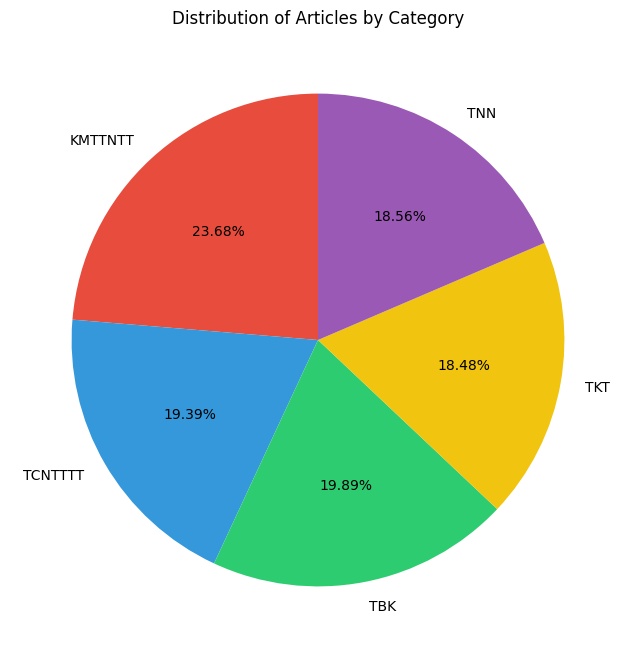

In [14]:
# temp = pd.read_csv('crawled.csv')
temp= pd.read_excel("data1.xlsx")

category_order = ['TNN', 'TKT', 'TBK', 'TCNTTTT', 'KMTTNTT']
custom_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F1C40F', '#9B59B6']

category_counts = temp['category'].value_counts().loc[category_order[::-1]]

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.2f%%', startangle=90, colors=custom_colors)
plt.title('Distribution of Articles by Category')

plt.show()

## Average sentence length

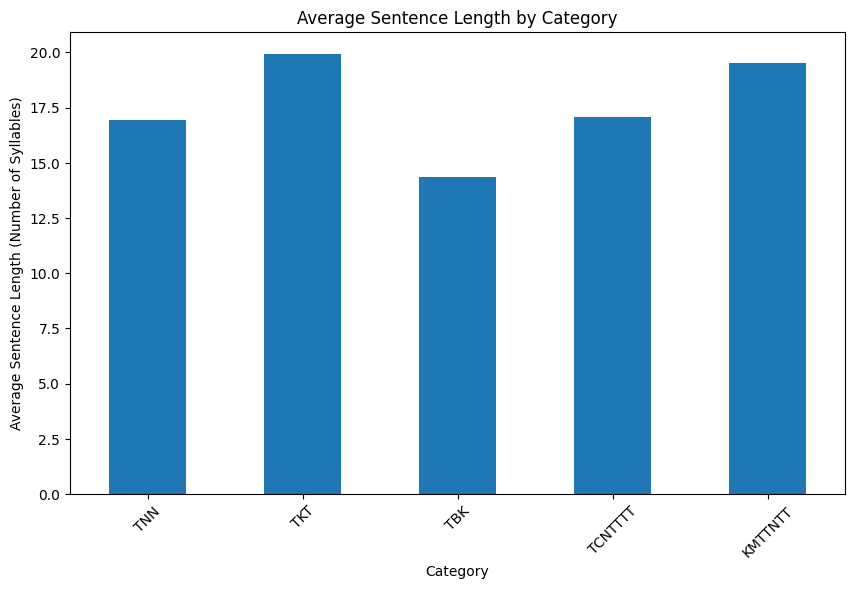

In [15]:
temp = pd.read_excel("data1.xlsx")

category_order = ['TNN', 'TKT', 'TBK', 'TCNTTTT', 'KMTTNTT']

temp['sentence_length'] = temp['title'].apply(lambda x: len(x.split()))
average_sentence_length = temp.groupby('category')['sentence_length'].mean().reindex(category_order)

plt.figure(figsize=(10, 6))
average_sentence_length.plot(kind='bar')
plt.title('Average Sentence Length by Category')
plt.xlabel('Category')
plt.ylabel('Average Sentence Length (Number of Syllables)')
plt.xticks(rotation=45)
plt.show()

## Word clouds (Most popular words by category)

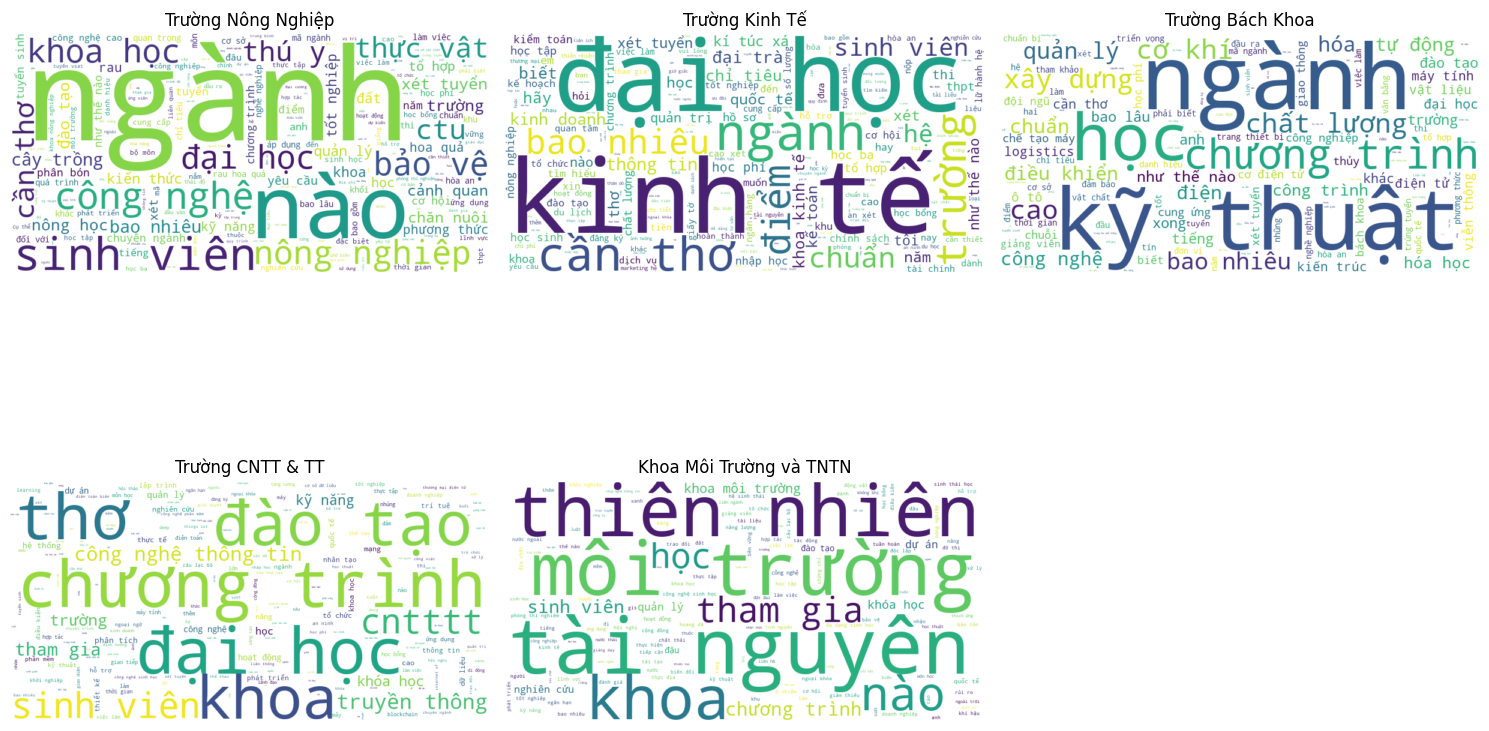

In [17]:
from collections import Counter

temp_tkn_df = tkn_df.copy()
temp_tkn_df['title'] = temp_tkn_df['title'].apply(lambda x: [word.replace('_', ' ') for word in x.split()])

category_names = ['Trường Nông Nghiệp', 'Trường Kinh Tế', 'Trường Bách Khoa', 'Trường CNTT & TT', 'Khoa Môi Trường và TNTN']
wordclouds = []

for category in range(5):
    category_data = temp_tkn_df[temp_tkn_df['category'] == category]

    all_titles = [item for sublist in category_data['title'] for item in sublist]
    word_counts = Counter(all_titles)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

    wordclouds.append(wordcloud)

plt.figure(figsize=(15, 10))

for i, wordcloud in enumerate(wordclouds):
    plt.subplot(2, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(category_names[i])

plt.tight_layout()
plt.show()

## Words with highest and lowest frequency in the data set

In [18]:
temp_tkn_df = tkn_df.copy()
temp_tkn_df['title'] = temp_tkn_df['title'].apply(lambda x: [word.replace('_', ' ') for word in x.split()])

all_words = [word for title in temp_tkn_df['title'] for word in title]
word_frequency = {}
total_titles = len(temp_tkn_df)

for word in all_words:
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1

word_frequencies = {word: freq / total_titles for word, freq in word_frequency.items()}

word_frequency_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency'])
word_frequency_df = word_frequency_df.sort_values(by='Frequency', ascending=False)

word_frequency_df = word_frequency_df.reset_index(drop=True)
word_frequency_df.head(10)

,Word,Frequency
0,ngành,0.461372
1,khoa,0.278700
2,đại học,0.263899
3,chương trình,0.239350
4,sinh viên,0.217690
5,tài nguyên,0.211191
6,học,0.207581
7,môi trường,0.198556
8,thiên nhiên,0.191336
9,kỹ thuật,0.172563


As we can see, there is no word whose frequency greater than 10%. Thus, we don't have any 'corpus-specific' stopwords in the dataset.

In [19]:
word_frequency_df.tail(10)

,Word,Frequency
732,đời sống,0.000361
733,ký hiệu,0.000361
734,sau này,0.000361
735,ưa chuộng,0.000361
736,bình thường,0.000361
737,trung học phổ thông,0.000361
738,lợi ích,0.000361
739,ktx,0.000361
740,tạo,0.000361
741,duy trì,0.000361


There's a lot of rare and weird words showing here.

## Zipf's Law distribution

In [22]:
# threshold_indices = [word_frequency_df[word_frequency_df['Frequency'] < (x/59958)].index[0] for x in [5, 10, 20]]
# threshold_colors = ['yellow', 'orange', 'red']

# plt.figure(figsize=(10, 6))
# plt.plot(word_frequency_df.index, word_frequency_df['Frequency'], linestyle='-')

# for threshold_index, threshold_color, threshold_value in zip(threshold_indices, threshold_colors, [5, 10, 20]):
#     plt.axvline(x=threshold_index, color=threshold_color, linestyle='--', label=f'{threshold_value} articles threshold')

# plt.title('Word Frequency vs. Rank')
# plt.xlabel('Rank')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.legend()
# plt.show()

# Feature extraction (TF-IDF)

In [23]:
corpus = tkn_df.copy()
corpus['title'] = corpus['title'].astype(str)

We removed rare words (and weird words caused by tokenizer) which are shown in less than 10 articles by setting the parameter min_df=10 to limit the vocabulary size. This will avoid overfitting and tremendously reduce computational cost later on.

In [24]:
vectorizer = TfidfVectorizer(min_df=10)
features = vectorizer.fit_transform(corpus['title'])

joblib.dump(vectorizer, 'models/tfidf.joblib')
tfidf_df = pd.DataFrame(data=features.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df['category'] = corpus['category']
tfidf_df.head()

,an_ninh,an_xét,anh,bao_gồm,bao_lâu,bao_nhiêu,biến_đổi,biết,blockchain,bách_khoa,...,đầu,đầu_ra,đầu_vào,đậu,đặc_biệt,đến,đối_với,đội_ngũ,ứng_dụng,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Number of features reduces to 4759 from 32437

# Data splitting

In [27]:
train_df, temp_df = train_test_split(tfidf_df, test_size=0.2, stratify=tfidf_df['category'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['category'], random_state=42)

train_df.to_csv('df/train_df.csv', index=False)
val_df.to_csv('df/val_df.csv', index=False)
test_df.to_csv('df/test_df.csv', index=False)

In [ ]:
# import pandas as pd
# import numpy as np

# # Đọc file Excel vào DataFrame
# file_path = 'data1.xlsx'
# df = pd.read_excel(file_path)

# # Hoán đổi các dòng trừ dòng đầu tiên
# first_row = df.iloc[0]   # Lưu dòng đầu tiên
# shuffled_df = df.iloc[1:].sample(frac=1).reset_index(drop=True)  # Hoán đổi các dòng còn lại
# result_df = pd.concat([first_row.to_frame().T, shuffled_df]).reset_index(drop=True)  # Ghép lại với dòng đầu tiên

# # Ghi DataFrame đã hoán đổi trở lại vào file Excel
# result_df.to_excel('data1_shuffled.xlsx', index=False)


In [ ]:
# import pandas as pd

# # Đọc file Excel đã được hoán đổi vào DataFrame
# file_path = 'data1_shuffled.xlsx'
# df = pd.read_excel(file_path)

# # Tính số lượng mẫu cho từng phần
# total_samples = len(df)
# train_size = int(total_samples * 0.8)
# val_size = int(total_samples * 0.1)
# test_size = total_samples - train_size - val_size  # Đảm bảo tổng số lượng mẫu

# # Chia DataFrame thành 3 phần
# train_df = df.iloc[:train_size]
# val_df = df.iloc[train_size:train_size + val_size]
# test_df = df.iloc[train_size + val_size:]

# # Ghi các phần này vào 3 file Excel khác nhau
# train_df.to_excel('train_df.xlsx', index=False)
# val_df.to_excel('val_df.xlsx', index=False)
# test_df.to_excel('test_df.xlsx', index=False)


# Hyperparameter tuning

In [28]:
%%notify
train_df = pd.read_csv('df/train_df.csv')
val_df = pd.read_csv('df/val_df.csv')
test_df = pd.read_csv('df/test_df.csv')

X_train = train_df.drop(columns=['category'])
y_train = train_df['category']

# print(X_train)
print(y_train)

X_val = val_df.drop(columns=['category'])
y_val = val_df['category']

X_test = test_df.drop(columns=['category'])
y_test = test_df['category']

0       1
1       4
2       1
3       2
4       3
       ..
2211    3
2212    4
2213    4
2214    4
2215    3
Name: category, Length: 2216, dtype: int64


<IPython.core.display.Javascript object>

## Naive Bayes

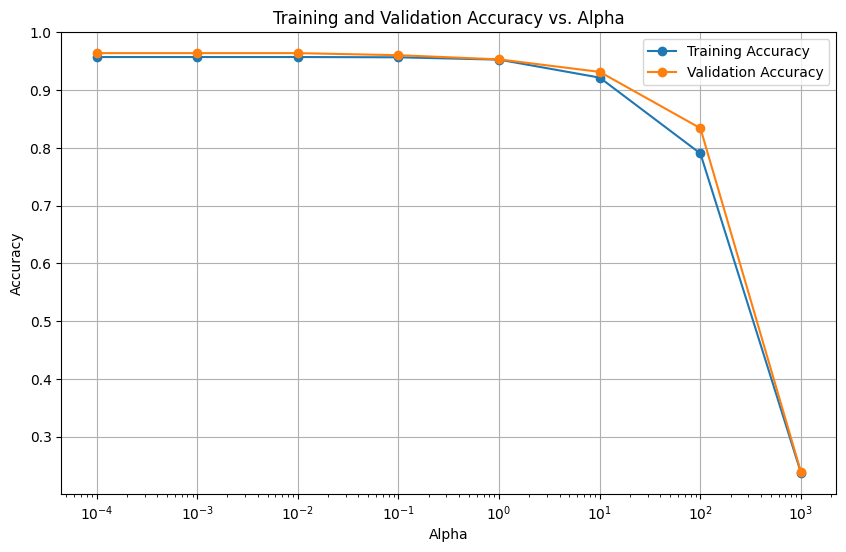

In [29]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha, fit_prior=True)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(alpha_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Alpha')
plt.grid(True)
plt.legend()
plt.show()

## k-Nearest Neighbors

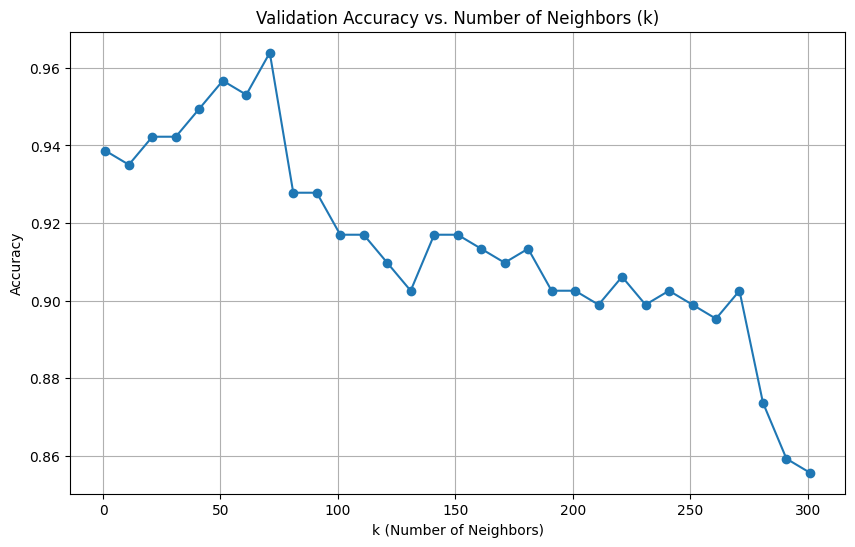

<IPython.core.display.Javascript object>

In [30]:
%%notify
k_values = range(1, 302, 10)
validation_accuracies = []

with joblib.parallel_backend('loky'):
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()

In [31]:
%%notify
param_grid = {
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

results = []

for weight in param_grid['weights']:
    for metric in param_grid['metric']:
        with joblib.parallel_backend('loky'):
            clf = KNeighborsClassifier(n_neighbors=101, weights=weight, metric=metric, n_jobs=-1)

            clf.fit(X_train, y_train)

            y_val_pred = clf.predict(X_val)
            accuracy = accuracy_score(y_val, y_val_pred)

            results.append({
                'weights': weight,
                'distance_metric': metric,
                'accuracy': accuracy
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='accuracy', ascending=False)
results_df.reset_index(drop=True, inplace=True)

display(results_df)

,weights,distance_metric,accuracy
0,distance,manhattan,0.960289
1,uniform,manhattan,0.949458
2,distance,cosine,0.945848
3,distance,euclidean,0.942238
4,uniform,euclidean,0.916968
5,uniform,cosine,0.913357


<IPython.core.display.Javascript object>

## Logistic Regression

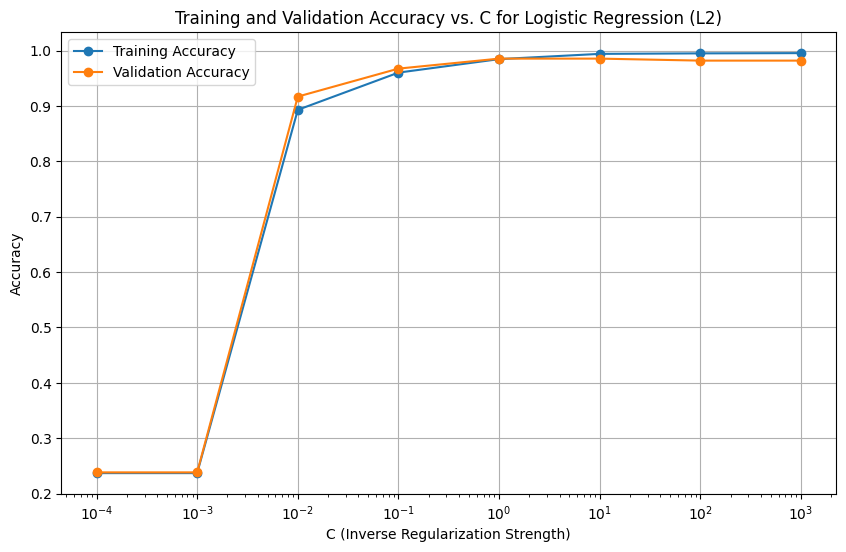

In [32]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for C in C_values:
    with joblib.parallel_backend('loky'):
        clf = LogisticRegression(C=C, max_iter=10000, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C for Logistic Regression (L2)')
plt.grid(True)
plt.legend()
plt.show()

## Support Vector Machine

c:\Users\Admin\anaconda3\envs\distillbert\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\distillbert\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\distillbert\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


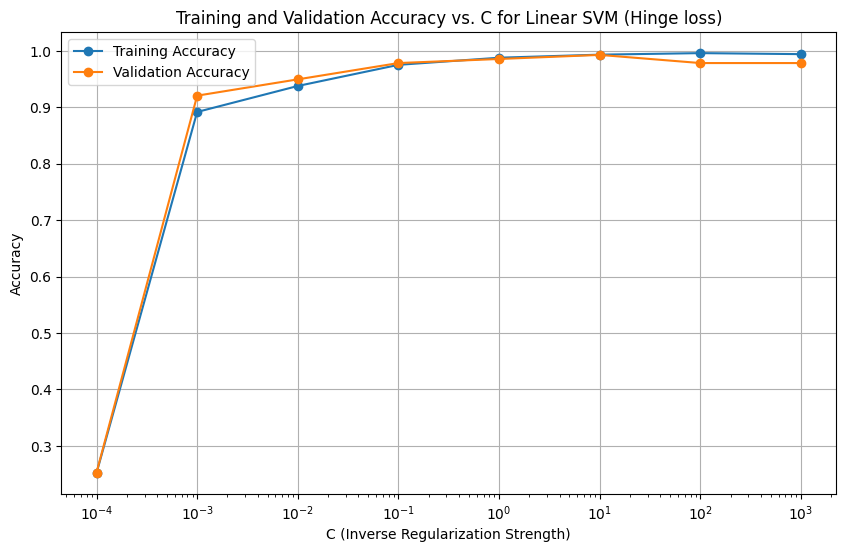

<IPython.core.display.Javascript object>

In [33]:
%%notify
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for C in C_values:
    clf = LinearSVC(C=C, loss='hinge', max_iter=10000)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, marker='o', label='Validation Accuracy')

plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C for Linear SVM (Hinge loss)')
plt.grid(True)
plt.legend()
plt.show()

## Random Forest

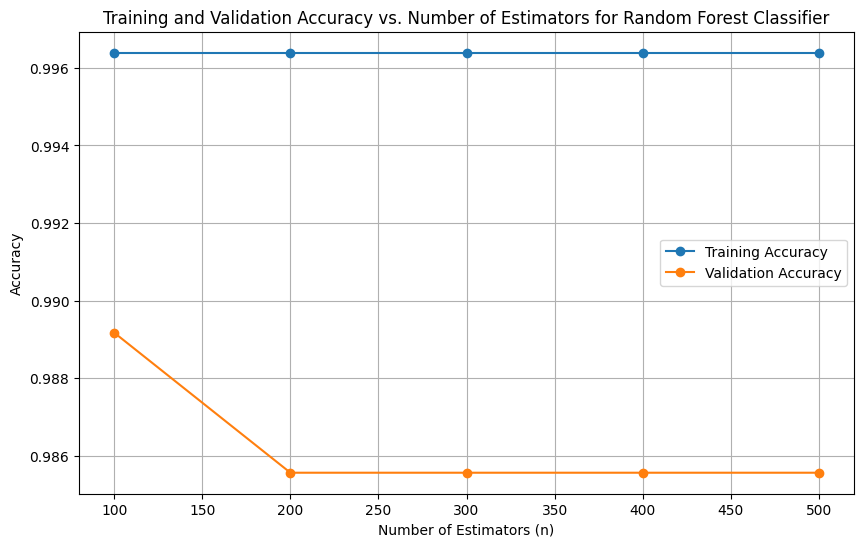

<IPython.core.display.Javascript object>

In [34]:
%%notify
n_values = range(100, 501, 100)
train_accuracies = []
validation_accuracies = []

for n in n_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(n_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Number of Estimators (n)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Estimators for Random Forest Classifier')
plt.grid(True)
plt.legend()
plt.show()

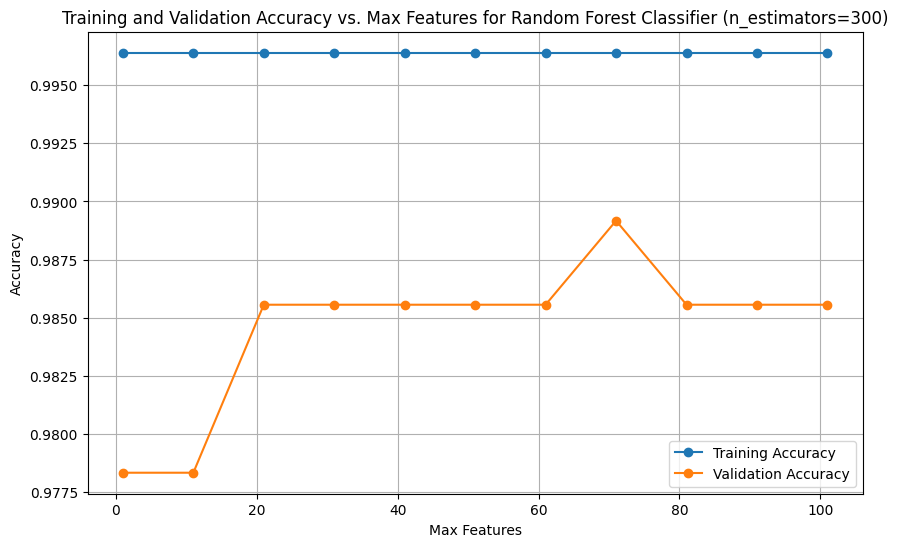

<IPython.core.display.Javascript object>

In [35]:
%%notify
max_features_values = range(1, 102, 10)
train_accuracies = []
validation_accuracies = []

for max_features in max_features_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=max_features, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_features_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(max_features_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Max Features for Random Forest Classifier (n_estimators=300)')
plt.grid(True)
plt.legend()
plt.show()

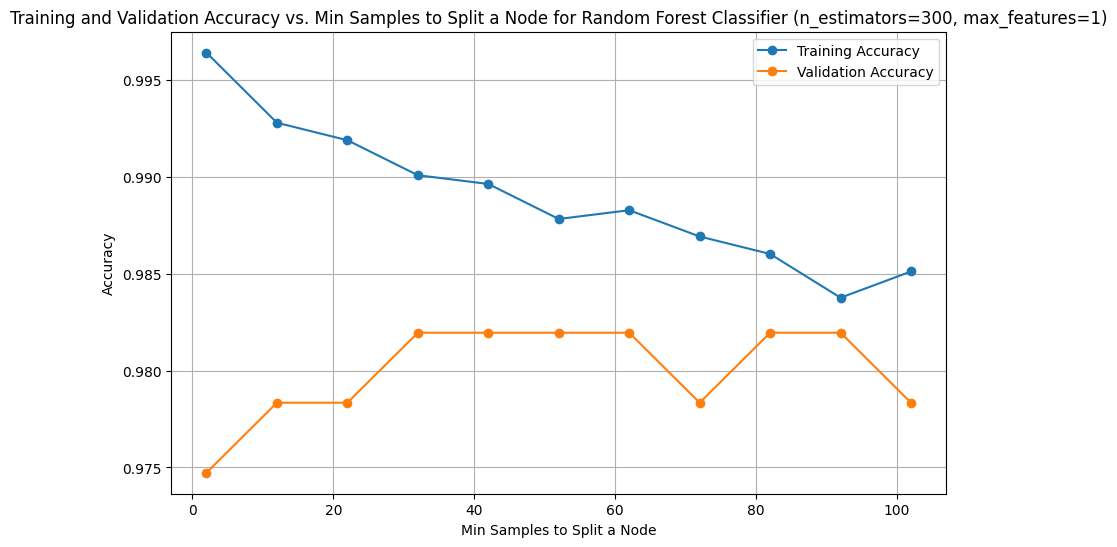

<IPython.core.display.Javascript object>

In [36]:
%%notify
min_samples_split_values = range(2, 103, 10)
train_accuracies = []
validation_accuracies = []

for min_samples_split in min_samples_split_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=min_samples_split, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(min_samples_split_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Min Samples to Split a Node')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Min Samples to Split a Node for Random Forest Classifier (n_estimators=300, max_features=1)')
plt.grid(True)
plt.legend()
plt.show()

# Model testing

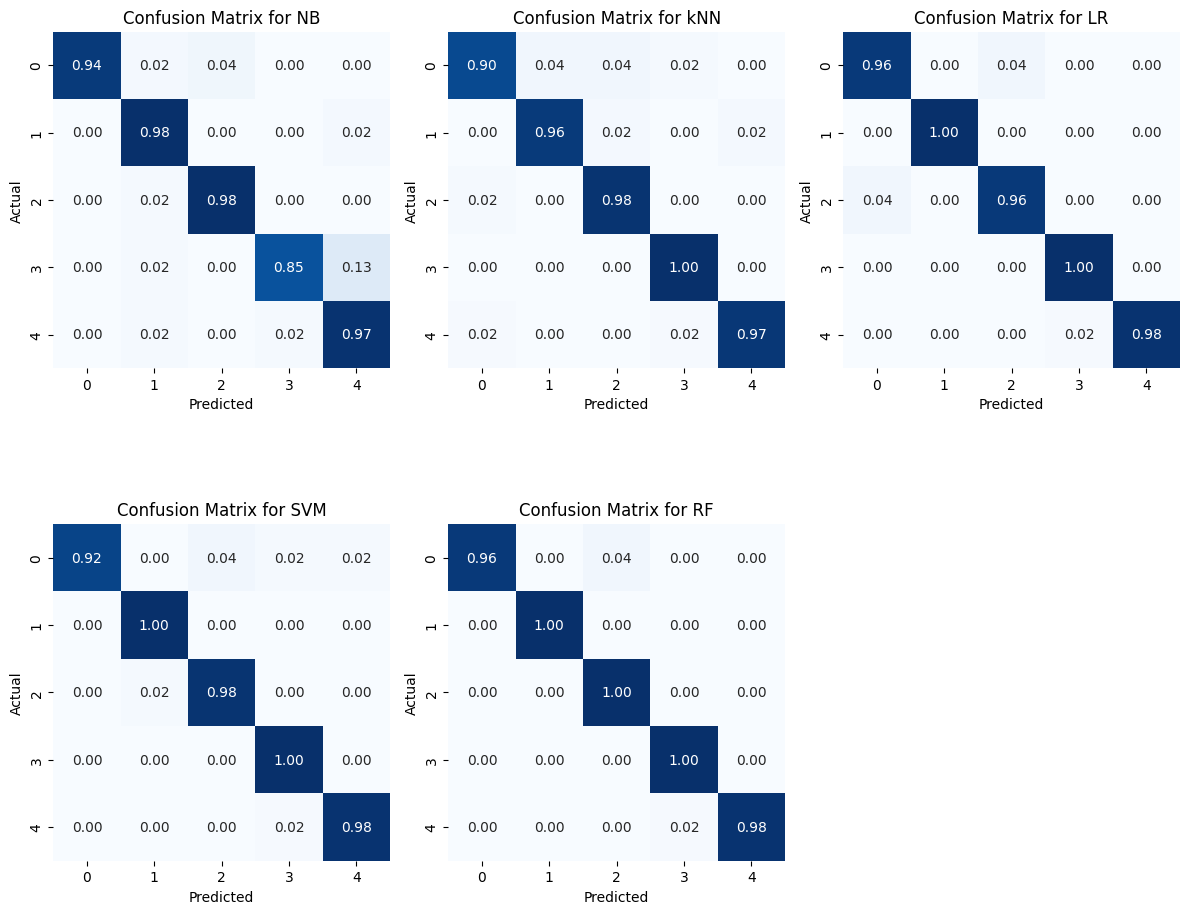

,Accuracy,Training Time (s),Testing Time (s)
NB,94.58%,0.01,0.00
kNN,96.39%,0.01,0.05
LR,98.19%,1.17,0.00
SVM,97.83%,0.10,0.00
RF,98.92%,0.49,0.06


<IPython.core.display.Javascript object>

In [37]:
%%notify
import time

clf0 = MultinomialNB(alpha=0.1)
clf1 = KNeighborsClassifier(n_neighbors=101, weights='distance', metric='cosine', n_jobs=-1)
clf2 = LogisticRegression(C=10, max_iter=10000, n_jobs=-1)
clf3 = LinearSVC(C=1, loss='hinge', max_iter=10000)
clf4 = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=12, n_jobs=-1)

classifiers = [clf0, clf1, clf2, clf3, clf4]
classifier_labels = ['NB', 'kNN', 'LR', 'SVM', 'RF']

training_times = []
testing_times = []
accuracies = []
confusion_matrices = []

for i, clf in enumerate(classifiers):
    with joblib.parallel_backend('loky'):
        start_time1 = time.time()
        clf.fit(X_train, y_train)
        end_time1 = time.time()
        training_time = end_time1 - start_time1
        training_times.append(training_time)

        start_time2 =time.time()
        y_pred = clf.predict(X_test)
        end_time2 = time.time()
        testing_time = end_time2 - start_time2
        testing_times.append(testing_time)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        confusion = confusion_matrix(y_test, y_pred, normalize='true')
        confusion_matrices.append(confusion)

#         model_filename = f'models/clf{i}.joblib'
#         joblib.dump(clf, model_filename)

plt.figure(figsize=(12, 10))

for i, clf_label in enumerate(classifier_labels):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(confusion_matrices[i], annot=True, fmt='.2f', cbar=False, cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_, square=True)
    plt.title(f'Confusion Matrix for {clf_label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

test_results = {'Accuracy': [f'{acc * 100:.2f}%' for acc in accuracies],
                'Training Time (s)': [f'{time:.2f}' for time in training_times],
                'Testing Time (s)': [f'{time:.2f}' for time in testing_times]}
display(pd.DataFrame(test_results, index=classifier_labels))

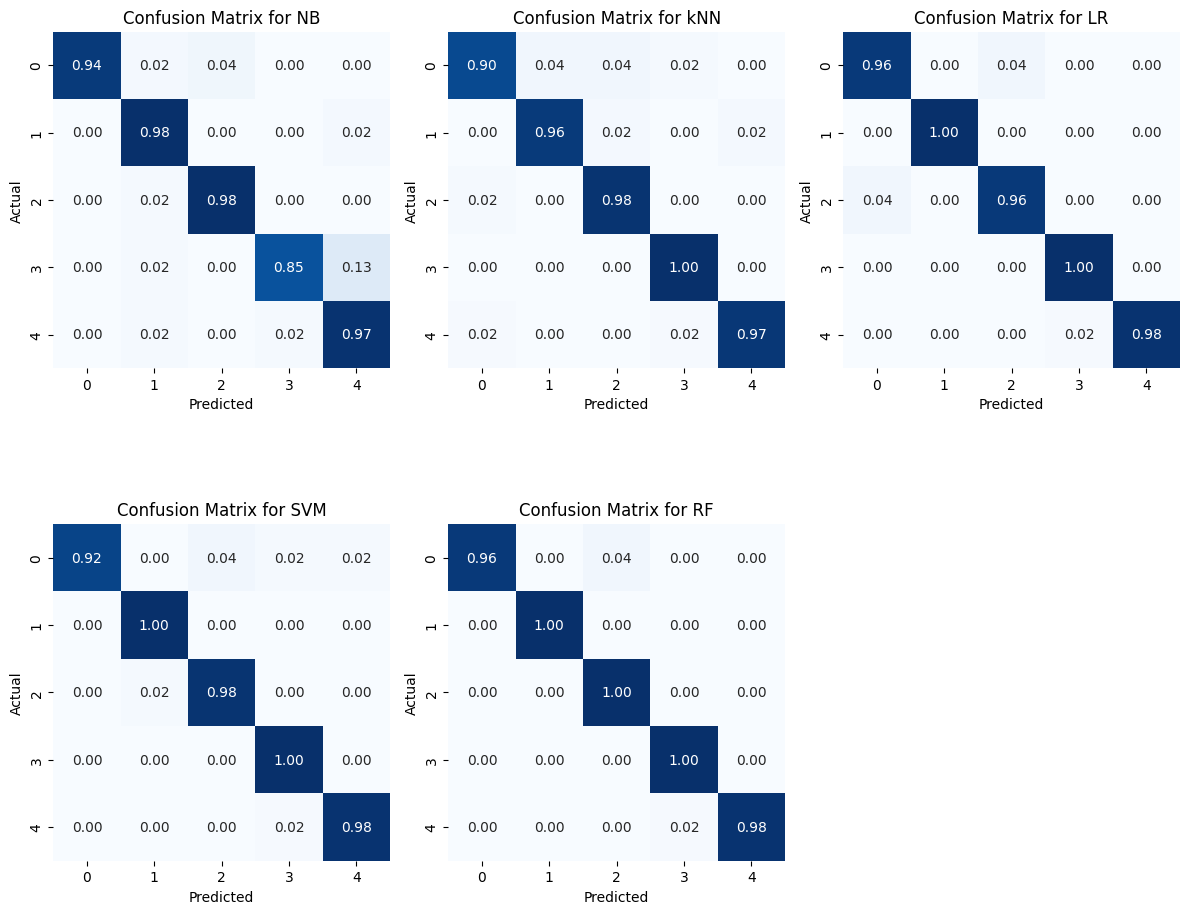

,Accuracy,F1 Score,Precision,Recall,Training Time (s),Testing Time (ms)
NB,94.58%,0.95,0.95,0.95,0.02,40.14
kNN,96.39%,0.96,0.96,0.96,0.01,104.09
LR,98.19%,0.98,0.98,0.98,1.60,3.53
SVM,97.83%,0.98,0.98,0.98,0.12,3.00
RF,98.92%,0.99,0.99,0.99,1.71,61.18


In [38]:
import time
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

clf0 = MultinomialNB(alpha=0.1)
clf1 = KNeighborsClassifier(n_neighbors=101, weights='distance', metric='cosine', n_jobs=-1)
clf2 = LogisticRegression(C=10, max_iter=10000, n_jobs=-1)
clf3 = LinearSVC(C=1, loss='hinge', max_iter=10000)
clf4 = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=12, n_jobs=-1)

classifiers = [clf0, clf1, clf2, clf3, clf4]
classifier_labels = ['NB', 'kNN', 'LR', 'SVM', 'RF']

training_times = []
testing_times = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
confusion_matrices = []

for i, clf in enumerate(classifiers):
    with joblib.parallel_backend('loky'):
        # Training
        start_time1 = time.time()
        clf.fit(X_train, y_train)
        end_time1 = time.time()
        training_time = end_time1 - start_time1
        training_times.append(training_time)

        # Testing
        start_time2 = time.time()
        y_pred = clf.predict(X_test)
        end_time2 = time.time()
        testing_time = (end_time2 - start_time2) * 1000  # tính thời gian bằng mili giây
        testing_times.append(testing_time)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        precision = precision_score(y_test, y_pred, average='weighted')
        precisions.append(precision)

        recall = recall_score(y_test, y_pred, average='weighted')
        recalls.append(recall)

        confusion = confusion_matrix(y_test, y_pred, normalize='true')
        confusion_matrices.append(confusion)

#         model_filename = f'models/clf{i}.joblib'
#         joblib.dump(clf, model_filename)

plt.figure(figsize=(12, 10))

for i, clf_label in enumerate(classifier_labels):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(confusion_matrices[i], annot=True, fmt='.2f', cbar=False, cmap='Blues', 
                xticklabels=clf.classes_, yticklabels=clf.classes_, square=True)
    plt.title(f'Confusion Matrix for {clf_label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

test_results = {'Accuracy': [f'{acc * 100:.2f}%' for acc in accuracies],
                'F1 Score': [f'{f1:.2f}' for f1 in f1_scores],
                'Precision': [f'{prec:.2f}' for prec in precisions],
                'Recall': [f'{rec:.2f}' for rec in recalls],
                'Training Time (s)': [f'{time:.2f}' for time in training_times],
                'Testing Time (ms)': [f'{time:.2f}' for time in testing_times]}
display(pd.DataFrame(test_results, index=classifier_labels))
